In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [2]:
plt.rcParams['figure.dpi'] = 100
sns.set_style('whitegrid')

In [3]:
COUNTRIES = [
    "Australia", "Austria", "Brazil", "Canada", "China",
    "France", "Germany", "India", "Italy", "Japan",
    "South Africa", "South Korea", "Spain", "United Kingdom", "United States",
    "Mexico", "Indonesia", "Singapore", "Thailand", "Poland",
    "Netherlands", "Sweden", "Switzerland", "Portugal", "Norway",
    "Denmark", "Finland", "Belgium", "Ireland", "Malaysia"
]

In [4]:
def calculate_foi(filename):

    try:
        df = pd.read_csv(filename, skiprows=1)
        df.columns = df.columns.str.strip()
        
        col_2023 = [c for c in df.columns if '2023' in c][0]
        col_2025 = [c for c in df.columns if '2025' in c][0]
        
        vals_2023 = pd.to_numeric(df[col_2023], errors='coerce')
        vals_2025 = pd.to_numeric(df[col_2025], errors='coerce')
        
        mean_2023 = vals_2023.mean()
        mean_2025 = vals_2025.mean()
        
        if mean_2023 > 0:
            return mean_2025 / mean_2023
        else:
            return np.nan
    except:
        return np.nan

foi_list = []
for country in COUNTRIES:
    foi = calculate_foi(f"{country}.csv")
    foi_list.append({'Country': country, 'FOI': foi})
    if not np.isnan(foi):
        print(f"  {country}: {foi:.3f}")

  Australia: 1.483
  Austria: 1.595
  Brazil: 1.403
  Canada: 1.529
  China: 2.440
  France: 1.656
  Germany: 1.815
  India: 1.330
  Italy: 1.678
  Japan: 1.402
  South Africa: 1.354
  South Korea: 2.154
  Spain: 1.515
  United Kingdom: 1.483
  United States: 1.610
  Mexico: 1.516
  Indonesia: 1.180
  Singapore: 1.543
  Thailand: 1.394
  Poland: 1.609
  Netherlands: 1.607
  Sweden: 1.745
  Switzerland: 1.533
  Portugal: 1.597
  Norway: 1.715
  Denmark: 1.773
  Finland: 1.664
  Belgium: 1.634
  Ireland: 1.524
  Malaysia: 1.489


In [5]:
def load_wb_data(filename, var_name):
    try:
        df = pd.read_csv(filename, skiprows=4)
        df.columns = df.columns.str.strip()
        
        name_col = 'Country Name'
        years = ['2019', '2020', '2021', '2022', '2023']
        
        available = [y for y in years if y in df.columns]
        
        if len(available) == 0:
            return pd.DataFrame(columns=['Country', var_name])
        
        cols_needed = [name_col] + available
        result = df[cols_needed].copy()
        
        for yr in available:
            result[yr] = pd.to_numeric(result[yr], errors='coerce')
        
        result[var_name] = result[available].mean(axis=1)
        result = result[[name_col, var_name]].rename(columns={name_col: 'Country'})
        
        return result
    except Exception as e:
        print(f"  Could not load {filename}: {str(e)}")
        return pd.DataFrame(columns=['Country', var_name])

gdp = load_wb_data('GDP_per_capita.csv', 'GDP_pc')
investment = load_wb_data('Investment_GCF.csv', 'Investment')
internet = load_wb_data('Internet_users.csv', 'Internet')
education = load_wb_data('Education_tertiary.csv', 'Education')


In [6]:
name_fixes = {
    'Korea, Rep.': 'South Korea',
    'Czechia': 'Czech Republic',
    'Turkiye': 'Turkey',
    'Viet Nam': 'Vietnam',
    'Egypt, Arab Rep.': 'Egypt'
}

for df in [gdp, investment, internet, education]:
    if 'Country' in df.columns:
        df['Country'] = df['Country'].replace(name_fixes)


In [7]:
foi_df = pd.DataFrame(foi_list)
foi_df = foi_df.dropna(subset=["FOI"]).reset_index(drop=True)
data = foi_df.copy()

for df, name in [(gdp, 'GDP_pc'), (investment, 'Investment'), 
                  (internet, 'Internet'), (education, 'Education'),
                  ]:
    if not df.empty:
        data = data.merge(df, on='Country', how='left')
        matched = data[name].notna().sum()
        print(f"  {name}: {matched}/{len(data)} matched")

data.to_csv('foi_merged_data.csv', index=False)


  GDP_pc: 30/30 matched
  Investment: 30/30 matched
  Internet: 30/30 matched
  Education: 30/30 matched


In [8]:
vars_to_describe = ['FOI', 'GDP_pc', 'Investment', 'Internet']
if 'Education' in data.columns and data['Education'].notna().sum() > 5:
    vars_to_describe.append('Education')

for var in vars_to_describe:
    if var in data.columns:
        vals = data[var].dropna()
        print(f"\n{var}:")
        print(f"  Mean = {vals.mean():.2f}, SD = {vals.std():.2f}")
        print(f"  Min = {vals.min():.2f}, Max = {vals.max():.2f}")
        print(f"  N = {len(vals)}")



FOI:
  Mean = 1.60, SD = 0.24
  Min = 1.18, Max = 2.44
  N = 30

GDP_pc:
  Mean = 41562.54, SD = 27386.72
  Min = 2213.13, Max = 96826.96
  N = 30

Investment:
  Mean = 24.57, SD = 5.47
  Min = 14.41, Max = 42.28
  N = 30

Internet:
  Mean = 86.55, SD = 12.23
  Min = 42.94, Max = 98.02
  N = 30

Education:
  Mean = 72.22, SD = 21.57
  Min = 22.88, Max = 108.70
  N = 30


In [9]:
core = data[['FOI', 'GDP_pc', 'Investment', 'Internet','Education']].dropna()

corr_mat = core.corr()
print(corr_mat.round(3))
print("\n")
for var in ['GDP_pc', 'Investment', 'Internet', 'Education']:
    r, p = stats.pearsonr(core['FOI'], core[var])
    print(f"  {var:15s}: r = {r:6.3f}, p = {p:.4f}")

              FOI  GDP_pc  Investment  Internet  Education
FOI         1.000   0.152       0.475     0.294      0.427
GDP_pc      0.152   1.000       0.068     0.699      0.688
Investment  0.475   0.068       1.000    -0.209      0.062
Internet    0.294   0.699      -0.209     1.000      0.730
Education   0.427   0.688       0.062     0.730      1.000


  GDP_pc         : r =  0.152, p = 0.4237
  Investment     : r =  0.475, p = 0.0079
  Internet       : r =  0.294, p = 0.1147
  Education      : r =  0.427, p = 0.0185


In [10]:
reg_data = core.copy()


if 'Education' in data.columns and data['Education'].notna().sum() == len(core):
  
    reg_data_with_edu = data[['FOI', 'GDP_pc', 'Investment', 'Internet', 'Education']].dropna()
    has_education = len(reg_data_with_edu) >= 25
else:
    has_education = False

n = len(reg_data)

y = reg_data['GDP_pc'].values
X_foi = reg_data[['FOI']].values
X_controls = reg_data[['Investment', 'Internet']].values
X_full = np.column_stack([X_foi, X_controls])
def calc_r2(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - y_true.mean())**2)
    return 1 - (ss_res / ss_tot)


# FOI Only

In [11]:
m1 = LinearRegression().fit(X_foi, y)
pred1 = m1.predict(X_foi)
r2_1 = calc_r2(y, pred1)
adj_r2_1 = 1 - (1-r2_1)*(n-1)/(n-2)

print(f"R² = {r2_1:.4f}, Adjusted R² = {adj_r2_1:.4f}")

R² = 0.0230, Adjusted R² = -0.0119


# Controls Only

In [12]:
m2 = LinearRegression().fit(X_controls, y)
pred2 = m2.predict(X_controls)
r2_2 = calc_r2(y, pred2)
adj_r2_2 = 1 - (1-r2_2)*(n-1)/(n-3)

print(f"R² = {r2_2:.4f}, Adjusted R² = {adj_r2_2:.4f}")

R² = 0.5358, Adjusted R² = 0.5014


# Full model

In [13]:
m3 = LinearRegression().fit(X_full, y)
pred3 = m3.predict(X_full)
r2_3 = calc_r2(y, pred3)
adj_r2_3 = 1 - (1-r2_3)*(n-1)/(n-4)

print(f"R² = {r2_3:.4f}, Adjusted R² = {adj_r2_3:.4f}")

r2_change = r2_3 - r2_2
f_change = (r2_change / 1) / ((1 - r2_3) / (n - 4))
p_change = 1 - stats.f.cdf(f_change, 1, n-4)


print(f"Change in R²: {r2_change:.4f}")
print(f"F-statistic: {f_change:.3f}")
print(f"p-value: {p_change:.4f}")

scaler = StandardScaler()
X_std = scaler.fit_transform(X_full)
y_std = (y - y.mean()) / y.std()
m_std = LinearRegression().fit(X_std, y_std)

print("\n")
labels = ['FOI', 'Investment', 'Internet']
for i, label in enumerate(labels):
    print(f"  {label:15s}: β = {m_std.coef_[i]:6.3f}")

R² = 0.5851, Adjusted R² = 0.5372
Change in R²: 0.0493
F-statistic: 3.091
p-value: 0.0905


  FOI            : β = -0.284
  Investment     : β =  0.383
  Internet       : β =  0.862


# Adding Education as Control

In [14]:
if has_education:
    n_edu = len(reg_data_with_edu)
    y_edu = reg_data_with_edu['GDP_pc'].values
    X_controls_edu = reg_data_with_edu[['Investment', 'Internet', 'Education']].values
    X_full_edu = reg_data_with_edu[['FOI', 'Investment', 'Internet', 'Education']].values
    

# Controls + Education

In [15]:
if has_education: 
    m4 = LinearRegression().fit(X_controls_edu, y_edu)
    pred4 = m4.predict(X_controls_edu)
    r2_4 = calc_r2(y_edu, pred4)
    adj_r2_4 = 1 - (1-r2_4)*(n_edu-1)/(n_edu-4)
    print(f"R² = {r2_4:.4f}, Adjusted R² = {adj_r2_4:.4f}")

R² = 0.5764, Adjusted R² = 0.5275


# Full model with Education

In [16]:
if has_education: 
    m5 = LinearRegression().fit(X_full_edu, y_edu)
    pred5 = m5.predict(X_full_edu)
    r2_5 = calc_r2(y_edu, pred5)
    adj_r2_5 = 1 - (1-r2_5)*(n_edu-1)/(n_edu-5)
    print(f"R² = {r2_5:.4f}, Adjusted R² = {adj_r2_5:.4f}")

R² = 0.6457, Adjusted R² = 0.5891


In [17]:
if has_education: 
    r2_change_edu = r2_5 - r2_4
    f_change_edu = (r2_change_edu / 1) / ((1 - r2_5) / (n_edu - 5))
    p_change_edu = 1 - stats.f.cdf(f_change_edu, 1, n_edu-5)
    print(f"Change in R²: {r2_change_edu:.4f}")
    print(f"F-statistic: {f_change_edu:.3f}")
    print(f"p-value: {p_change_edu:.4f}")


Change in R²: 0.0693
F-statistic: 4.893
p-value: 0.0363


# FOI vs GDP

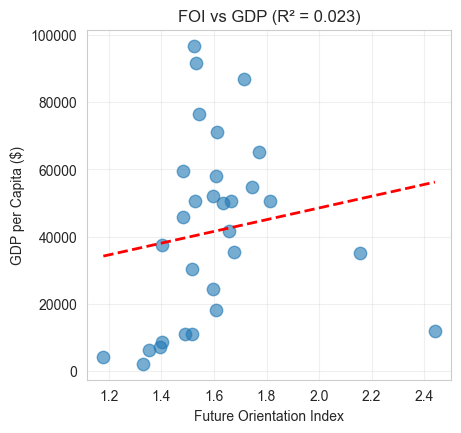

In [18]:
fig = plt.figure(figsize=(16, 10))
ax1 = plt.subplot(2, 3, 1)
ax1.scatter(reg_data['FOI'], reg_data['GDP_pc'], alpha=0.6, s=80)
x_line = np.linspace(reg_data['FOI'].min(), reg_data['FOI'].max(), 100)
y_line = m1.intercept_ + m1.coef_[0] * x_line
ax1.plot(x_line, y_line, 'r--', linewidth=2)
ax1.set_xlabel('Future Orientation Index')
ax1.set_ylabel('GDP per Capita ($)')
ax1.set_title(f'FOI vs GDP (R² = {r2_1:.3f})')
ax1.grid(alpha=0.3)


# FOI vs Investment

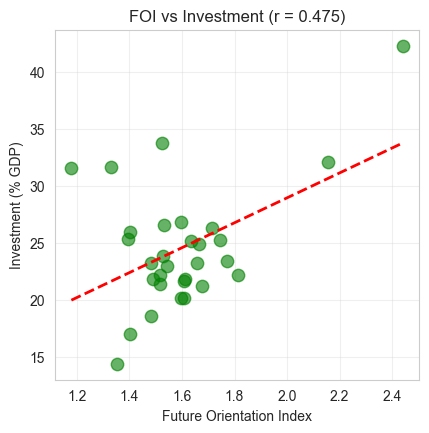

In [19]:
fig = plt.figure(figsize=(16, 10))
ax2 = plt.subplot(2, 3, 2)
ax2.scatter(reg_data['FOI'], reg_data['Investment'], alpha=0.6, s=80, color='green')
m_inv = LinearRegression().fit(reg_data[['FOI']], reg_data['Investment'])
y_inv = m_inv.intercept_ + m_inv.coef_[0] * x_line
r_inv, _ = stats.pearsonr(reg_data['FOI'], reg_data['Investment'])
ax2.plot(x_line, y_inv, 'r--', linewidth=2)
ax2.set_xlabel('Future Orientation Index')
ax2.set_ylabel('Investment (% GDP)')
ax2.set_title(f'FOI vs Investment (r = {r_inv:.3f})')
ax2.grid(alpha=0.3)

# Model comparison

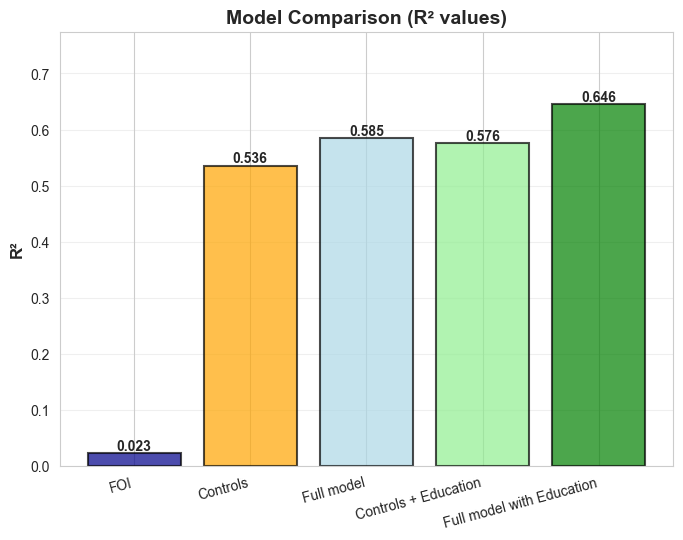

In [20]:
if has_education:
    fig = plt.figure(figsize=(20, 10))
    ax3 = plt.subplot(2, 3, 3)
    
    models = ['FOI', 'Controls', 'Full model', 'Controls + Education', 'Full model with Education']
    
    r2_vals = [r2_1, r2_2, r2_3, r2_4, r2_5]
    colors = ['darkblue', 'orange', 'lightblue', 'lightgreen', 'green']
    bars = ax3.bar(models, r2_vals, alpha=0.7, color=colors, edgecolor='black', linewidth=1.5)
    
else:
    fig = plt.figure(figsize=(16, 10))
    ax3 = plt.subplot(2, 3, 3)
    models = ['FOI only', 'Controls only', 'Full model']
    r2_vals = [r2_1, r2_2, r2_3]
    bars = ax3.bar(models, r2_vals, alpha=0.7, color=['darkblue', 'orange', 'green'], edgecolor='black', linewidth=1.5)

ax3.set_ylabel('R²', fontsize=12, fontweight='bold')
ax3.set_title('Model Comparison (R² values)', fontsize=14, fontweight='bold')
ax3.set_ylim(0, max(r2_vals) * 1.2)

for bar, val in zip(bars, r2_vals):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.xticks(rotation=15, ha='right', fontsize=10)

ax3.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Standardized coefficients

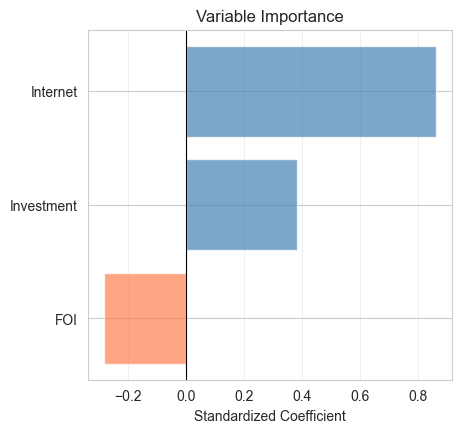

In [21]:
fig = plt.figure(figsize=(16, 10))
ax4 = plt.subplot(2, 3, 4)
colors = ['steelblue' if x > 0 else 'coral' for x in m_std.coef_]
ax4.barh(labels, m_std.coef_, color=colors, alpha=0.7)
ax4.axvline(0, color='black', linewidth=0.8)
ax4.set_xlabel('Standardized Coefficient')
ax4.set_title('Variable Importance')
ax4.grid(alpha=0.3, axis='x')

# Residuals

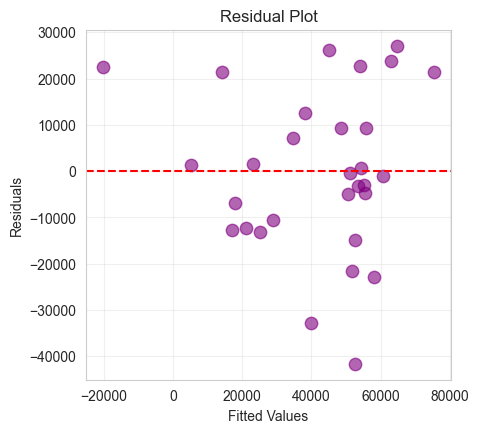

In [22]:
fig = plt.figure(figsize=(16, 10))
ax5 = plt.subplot(2, 3, 5)
residuals = y - pred3
ax5.scatter(pred3, residuals, alpha=0.6, s=80, color='purple')
ax5.axhline(0, color='red', linestyle='--', linewidth=1.5)
ax5.set_xlabel('Fitted Values')
ax5.set_ylabel('Residuals')
ax5.set_title('Residual Plot')
ax5.grid(alpha=0.3)

# Correlation heatmap

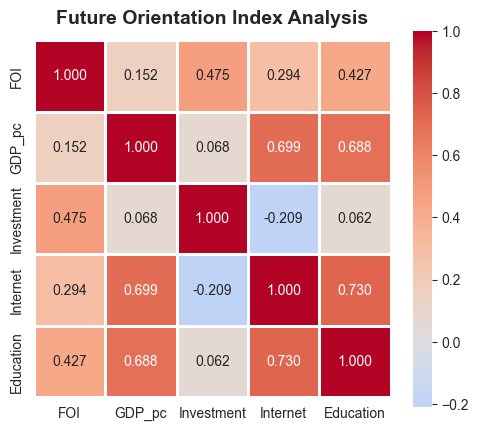

In [23]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap( corr_mat,
annot=True,
fmt=".3f", cmap="coolwarm", center=0,
square=True, linewidths=1,
ax=ax, cbar_kws={"shrink": 0.8}
)
ax.set_title(
"Future Orientation Index Analysis", fontsize=14,
fontweight="bold",
pad=12
)
plt.tight_layout() 
plt.show()